[View in Colaboratory](https://colab.research.google.com/github/vincentei/predict_power_prices/blob/master/power_prices_LSTM_24h.ipynb)

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
import datetime as dt
from keras.layers import TimeDistributed
from keras.layers import RepeatVector

In [58]:
#https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
"""
Instead of phrasing the past observations as separate input features, 
we can use them as time steps of the one input feature, 
which is indeed a more accurate framing of the problem.

"""

'\nInstead of phrasing the past observations as separate input features, \nwe can use them as time steps of the one input feature, \nwhich is indeed a more accurate framing of the problem.\n\n'

In [0]:
needUpload = False

In [0]:
if needUpload == True:
  from google.colab import files

  uploaded = files.upload()

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

In [0]:
# import the data
df = pd.read_csv('make_prices_lstm2.csv',usecols=['price','year'])

In [62]:
df['price'] = df['price']/100
df.head(2)

,price,year
0,0.3243,2014
1,0.3249,2014


In [63]:
# calc number of days in df, reshape df into (numdays,24)
numdays = int(len(df)/24)
dataX = df['price'].values.reshape(numdays,24)
print("There are {} days in the dataset".format(numdays))

There are 1597 days in the dataset


In [64]:
# check
dataX[0:2]

array([[0.3243, 0.3249, 0.2843, 0.2763, 0.2599, 0.2447, 0.172 , 0.0996,
        0.0949, 0.2655, 0.276 , 0.2844, 0.2869, 0.2883, 0.2906, 0.294 ,
        0.3211, 0.3499, 0.4496, 0.3999, 0.3496, 0.3287, 0.2873, 0.2785],
       [0.2791, 0.26  , 0.0496, 0.0099, 0.1999, 0.2842, 0.2934, 0.3846,
        0.4335, 0.4694, 0.55  , 0.66  , 0.6409, 0.6293, 0.5943, 0.5244,
        0.55  , 0.7808, 0.667 , 0.5353, 0.5244, 0.4496, 0.3547, 0.3064]])

In [65]:
# dataY is the same but all shifted
dataY = dataX[1:]
dataY[0]

array([0.2791, 0.26  , 0.0496, 0.0099, 0.1999, 0.2842, 0.2934, 0.3846,
       0.4335, 0.4694, 0.55  , 0.66  , 0.6409, 0.6293, 0.5943, 0.5244,
       0.55  , 0.7808, 0.667 , 0.5353, 0.5244, 0.4496, 0.3547, 0.3064])

In [0]:
# remove one day from dataX and check shape
dataX = dataX[:-1]

In [67]:
print(dataX.shape)
print(dataY.shape)

(1596, 24)
(1596, 24)


In [0]:
# split in train and test
numtraindays = 3*365
trainX = dataX[:numtraindays]
testX = dataX[numtraindays:]

trainY = dataY[:numtraindays]
testY = dataY[numtraindays:]

In [69]:
# reshape X into [samples,timestep,features]
trainX = trainX.reshape(numtraindays,24,1)
trainY = trainY.reshape(numtraindays,24,1)
print(trainX.shape)
print(trainY.shape)

(1095, 24, 1)
(1095, 24, 1)


In [70]:
len(testX)

501

In [71]:
numtestdays = int(len(testX))
testX = testX.reshape(numtestdays,24,1)
testY = testY.reshape(numtestdays,24,1)
print(testX.shape)
print(testY.shape)

(501, 24, 1)
(501, 24, 1)


In [0]:
# reshape X into [samples,timestep,features]
#numtestdays = numdays - numtraindays
#testX = testX.reshape(numtraindays,24,1)
#testY = testY.reshape(numtraindays,24,1)
#print(testX.shape)
#print(testY.shape)

In [0]:
# fix random seed for reproducibility
np.random.seed(5)

In [0]:
# example repeat vector
#https://machinelearningmastery.com/how-to-use-an-encoder-decoder-lstm-to-echo-sequences-of-random-integers/


In [84]:
# define LSTM configuration
n_neurons = 1
batch_size = 1
n_epoch = 4
# create LSTM
model = Sequential()
model.add(LSTM(n_neurons, input_shape=(24, 1), return_sequences=True))
#model.add(RepeatVector(24))
model.add(TimeDistributed(Dense(1,activation = 'linear')))
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())
# train LSTM
model.fit(trainX, trainY, epochs=n_epoch, batch_size=batch_size, verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 24, 1)             12        
_________________________________________________________________
time_distributed_10 (TimeDis (None, 24, 1)             2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/4
 - 16s - loss: 0.0195
Epoch 2/4
 - 15s - loss: 0.0090
Epoch 3/4
 - 15s - loss: 0.0082
Epoch 4/4
 - 15s - loss: 0.0078


In [0]:
# shampoo multistep
#https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
#https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/

In [76]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
print(testPredict.shape)

(501, 24, 1)


In [77]:
# calc the mean absolute error
print(testY.shape)
a = testY.reshape(501*24,1)
b = testPredict.reshape(501*24,1)
mean_absolute_error(a, b)*100

(501, 24, 1)


7.494107198009313

In [38]:
idx = df['year'] ==2014
df_info = df.loc[idx]
df_info.head(2)

,price,year
0,0.3243,2014
1,0.3249,2014


In [39]:
print(trainPredict.shape)

(1095, 24, 1)


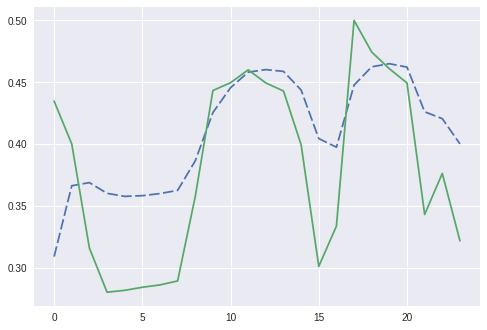

In [40]:
day = 11
plt.plot(trainPredict[day], dashes=[6, 2])
plt.plot(trainX[day])
plt.show()

In [0]:
#http://www.jakob-aungiers.com/articles/a/LSTM-Neural-Network-for-Time-Series-Prediction

In [0]:
#result = np.array(result)

In [0]:
# shape (n_samples, sequence_length, num_features + num_predictions)
#print("Shape of data: {}".format(np.shape(result)))

In [0]:
#https://blog.keras.io/building-autoencoders-in-keras.html